<a href="https://colab.research.google.com/github/evergreenllc2020/clip/blob/main/Beyond_Tags_Stock_Semantic_Search_on_images_with_OpenAI_CLIP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [4]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.0


In [5]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:18tcmalloc: large alloc 1147494400 bytes == 0x55d82d5d8000 @  0x7f10db8a6615 0x55d7f343806c 0x55d7f3517eba 0x55d7f343ae8d 0x55d7f352c99d 0x55d7f34aefe9 0x55d7f34a9b0e 0x55d7f343c77a 0x55d7f34aee50 0x55d7f34a9b0e 0x55d7f343c77a 0x55d7f34ab86a 0x55d7f352d7c6 0x55d7f34aaee2 0x55d7f352d7c6 0x55d7f34aaee2 0x55d7f352d7c6 0x55d7f34aaee2 0x55d7f352d7c6 0x55d7f35af431 0x55d7f3510049 0x55d7f347ac84 0x55d7f343b8e9 0x55d7f34afade 0x55d7f343c69a 0x55d7f34aaa45 0x55d7f34a9e0d 0x55d7f343c77a 0x55d7f34aaa45 0x55d7f343c69a 0x55d7f34aaa45
     |█████████████████████████████▏  | 1055.7MB 51.1MB/s eta 0:00:02tcmalloc: large alloc 1434370048 bytes == 0x55d871c2e000 @  0x7f10db8a6615 0x55d7f343806c 0x55d7f3517eba 0x55d7f343ae8d 0x55d7f352c99d 0x55d7f34aefe9 0x55d7f34a9b0e 0x55d7f343c77a 0x55d7f34aee50 0x55d7f34a9b0e 0x55d7f343c77a 0x55d7f34ab86a 0x55d7f352d7c6 0x55d7f34aaee2 

In [6]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu110


# Downloading the model

CLIP models are distributed as TorchScript modules.

In [7]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [8]:
! wget {MODELS["ViT-B/32"]} -O model.pt

--2021-04-18 06:13:31--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M   132MB/s    in 2.6s    

2021-04-18 06:13:34 (132 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [9]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.



In [10]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# Text Preprocessing

We use a case-insensitive tokenizer. The tokenizer code is hidden in the second cell below

In [11]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-04-18 06:14:42--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.02s   

2021-04-18 06:14:42 (79.1 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [21]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


# Semantic search on images retrived from Pixabay

Author for the code part below : Ramsri Goutham Golla

Linkedin: https://www.linkedin.com/in/ramsrig/

Twitter: https://twitter.com/ramsri_goutham

**Note:** I would strongly encourage you to sign in to Pixabay https://pixabay.com/api/docs/ and get your api key and replace in the cell below to run through this demo.

In [12]:
original_api = "https://pixabay.com/api/?key="
# Replace your pixabay api key below
#pixabay_api_key = "4377721-e991a1fc0a90ce550d4e95cde"
pixabay_api_key = "21212245-6ff7beee229313f0a4da95068"

In [13]:
#  Necessary installations
!pip install ipyplot==1.1.0

In [140]:
semantic_search_phrase = "white rose on red background"
search_keyword = "rose"


**Search pixabay with the keyword and retrieve top N images**

In [141]:
import requests
import PIL
from io import BytesIO
import ipyplot
import json


stock_api_original = "https://stock.adobe.com/Ajax/Search?filters%5Bcontent_type%3Aphoto%5D=1&filters%5Bcontent_type%3Aillustration%5D=1&filters%5Bcontent_type%3Azip_vector%5D=1&filters%5Bcontent_type%3Avideo%5D=1&filters%5Bcontent_type%3Atemplate%5D=1&filters%5Bcontent_type%3A3d%5D=1&filters%5Binclude_stock_enterprise%5D=0&filters%5Bcontent_type%3Aimage%5D=1&k={query}+&order=relevance&safe_search=1&limit=30&search_page=1&search_type=usertyped&acp=&aco={query}+&get_facets=0"


no_to_retrieve = 30
stock_api = stock_api_original.format(query=search_keyword)
response = requests.get(stock_api)
output = response.json()
response_dict = json.loads(response.text)
items = response_dict["items"]
all_images =[]
for item in items:
  item = items[item]
  imageurl = item['content_thumb_large_url']
  response = requests.get(imageurl)
  print(imageurl)
  image = PIL.Image.open(BytesIO(response.content)).convert("RGB")
  all_images.append(image)

print ("Total no of images retrived: ",len(all_images))




https://as1.ftcdn.net/jpg/04/21/41/78/500_F_421417868_6RSUuRQFWX0CuQXR5UVCJIB5aCLilcVi.jpg
https://as2.ftcdn.net/jpg/04/21/77/95/500_F_421779593_iGTfEQqRqJp54VrckTwT6pfFQwwyTiL1.jpg
https://as1.ftcdn.net/jpg/01/14/13/82/500_F_114138294_vaej1rJGvSkAmW2fMv2jagwxgoEEnuAZ.jpg
https://as2.ftcdn.net/jpg/03/15/32/63/500_F_315326320_P4tAYpgDgDZ3mbpXnVGNmylhsKCN2WFH.jpg
https://as1.ftcdn.net/jpg/02/19/24/18/500_F_219241850_NdJYUDlUzkKycL9DJMA64JlCTtW7VjAj.jpg
https://as1.ftcdn.net/jpg/01/05/57/38/500_F_105573812_cvD4P5jo6tMPhZULX324qUYFbNpXlisD.jpg
https://as1.ftcdn.net/jpg/02/65/52/50/500_F_265525056_Wr6iuaYqtpMItG1QWjfDdhDSGxSyUAXq.jpg
https://as1.ftcdn.net/jpg/01/24/42/84/500_F_124428436_sCbMb00jrSuy9FLO417hC1m9aqwC445n.jpg
https://as1.ftcdn.net/jpg/02/16/41/64/500_F_216416432_iUUhWPaZP6QVDKm79WymJYzlmHDV4vKc.jpg
https://as2.ftcdn.net/jpg/01/56/99/73/500_F_156997372_hQv7AFyrlFt2JcAhwK5phrv3A4aAuqkR.jpg
https://as1.ftcdn.net/jpg/02/48/61/76/500_F_248617600_sSROyrYx0vplJQyFECZ7eVOJhVLykanS.jpg


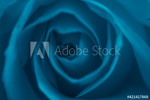
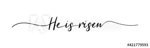
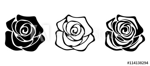
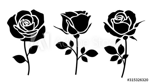
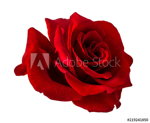
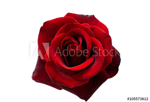
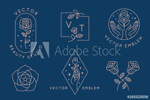
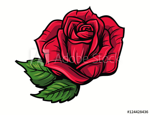
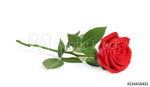
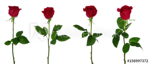
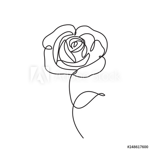
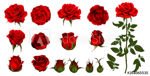
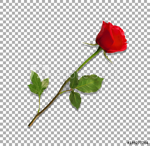
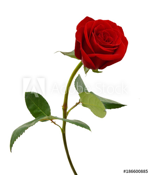
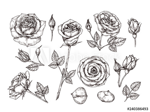
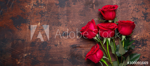
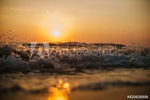
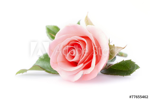
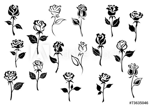
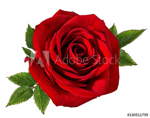
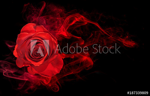
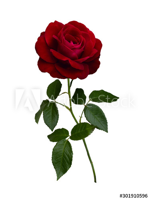
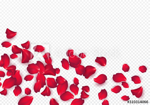
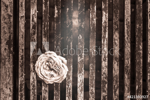
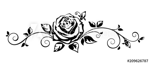
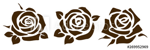
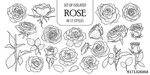
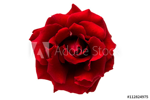
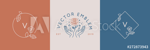
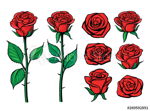
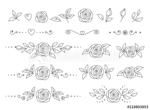
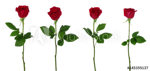
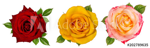


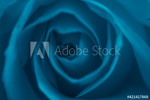
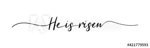
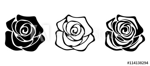
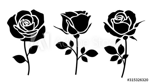
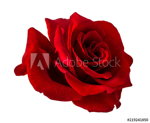
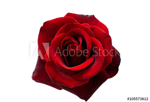
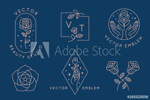
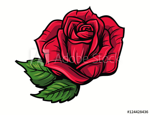
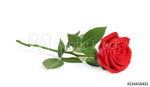
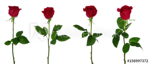
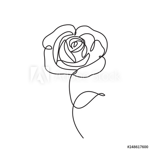
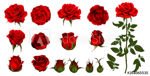
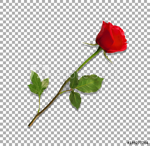
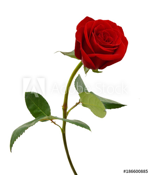
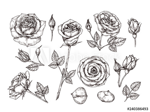
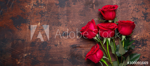
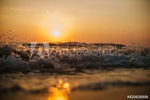
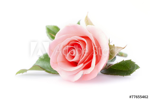
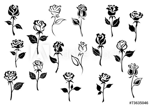
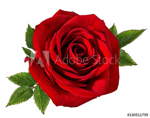
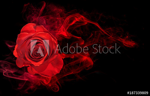
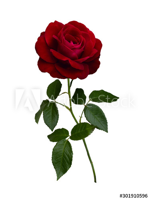
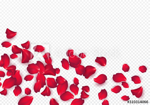
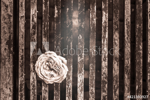
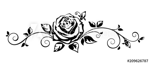
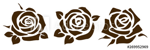
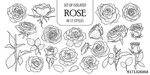
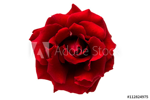
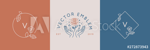
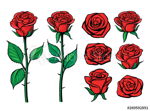
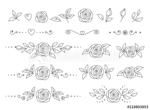
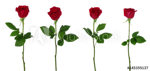
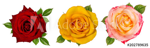

In [143]:
# plot the top 50 (max) retrived images
ipyplot.plot_images(all_images,max_images =50,img_width=150)

In [144]:
# preprocess the retrived images for openAI CLIP and perform normalization

images = [preprocess(im) for im in all_images]
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

tokenizer = SimpleTokenizer()

def get_text_features(sentence):
  text_tokens = [tokenizer.encode("%s "%(sentence) + "<|endoftext|>")]
  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)
    
  text_input = text_input.cuda()
  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

  return text_features

def get_top_N_semantic_similarity(similarity_list,N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse= True)
  top_N_images = []
  scores=[]
  for index,score in results[:N]:
    scores.append(score)
    top_N_images.append(all_images[index])
  return scores,top_N_images

**Seacrh with any phrase to filter from the retrieved images**

scores  [0.29981396, 0.29252672, 0.28941762]



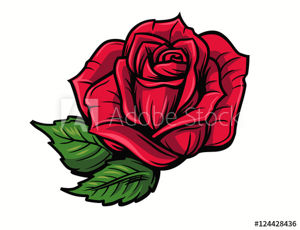
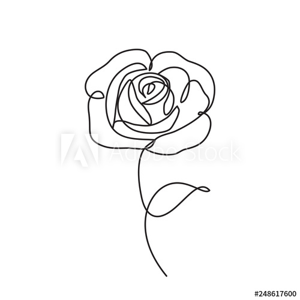
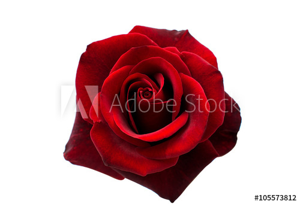


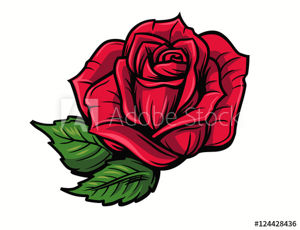
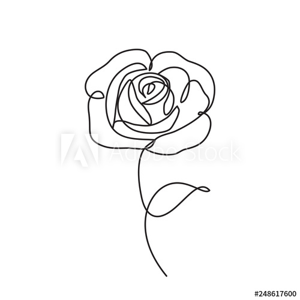
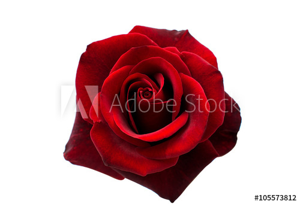

In [146]:
semantic_search_phrase = "pink rose"
text_features_extracted = get_text_features(semantic_search_phrase)
similarity = text_features_extracted.cpu().numpy() @ image_features.cpu().numpy().T

similarity = similarity[0]
scores,imgs= get_top_N_semantic_similarity(similarity,N=3)
print ("scores ",scores)
ipyplot.plot_images(imgs,img_width=300)


scores  [0.28974044, 0.27897805, 0.2762548]



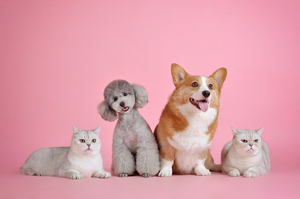
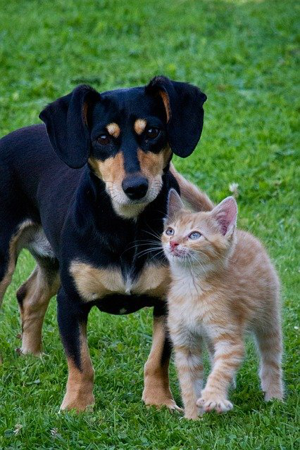
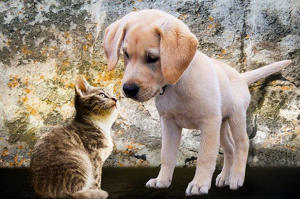


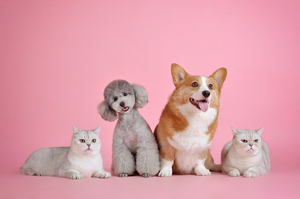
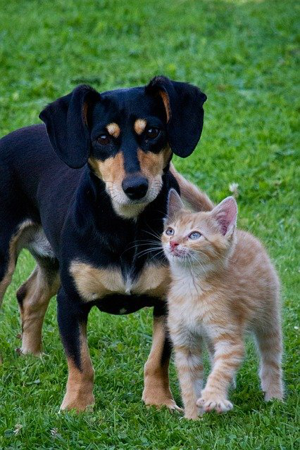
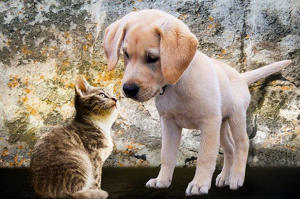

In [46]:
semantic_search_phrase = "black dog with brown cat and pink background"
text_features_extracted = get_text_features(semantic_search_phrase)
similarity = text_features_extracted.cpu().numpy() @ image_features.cpu().numpy().T

similarity = similarity[0]
scores,imgs= get_top_N_semantic_similarity(similarity,N=3)
print ("scores ",scores)
ipyplot.plot_images(imgs,img_width=300)

scores  [0.28089082, 0.26527902, 0.2597538]



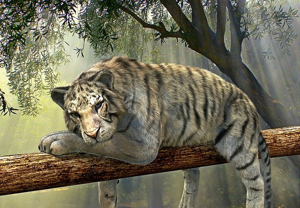
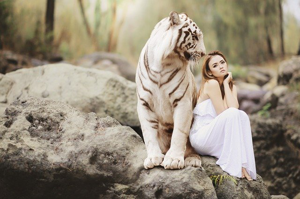
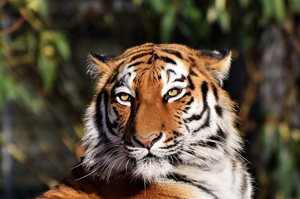


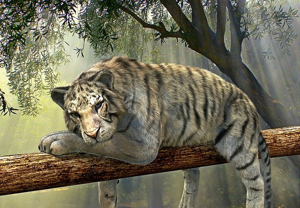
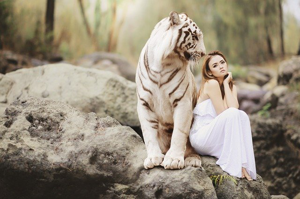
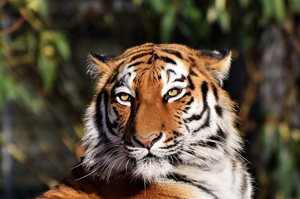

In [ ]:
semantic_search_phrase = "Tiger sitting on a branch"
text_features_extracted = get_text_features(semantic_search_phrase)
similarity = text_features_extracted.cpu().numpy() @ image_features.cpu().numpy().T

similarity = similarity[0]
scores,imgs= get_top_N_semantic_similarity(similarity,N=3)
print ("scores ",scores)
ipyplot.plot_images(imgs,img_width=300)